# Notebook complet Student Habits → Exam Score

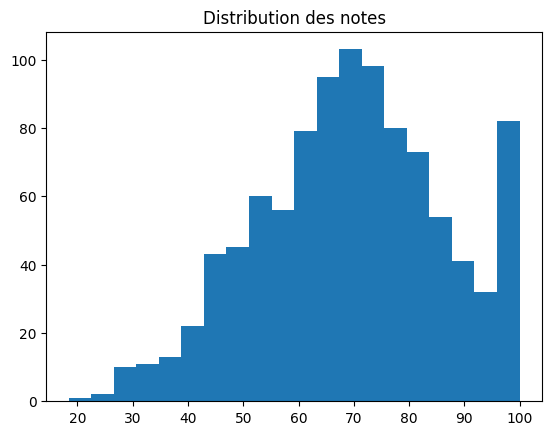

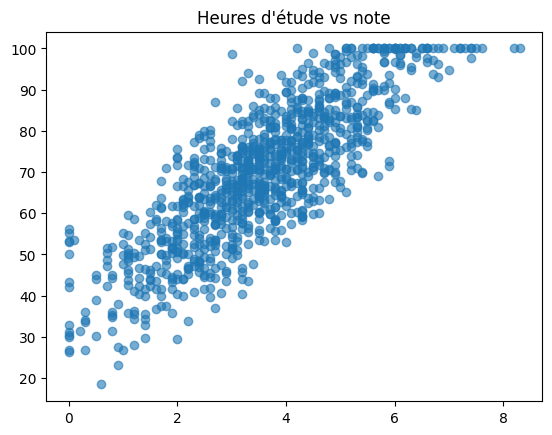

R2: 0.8848242188185838
MAE: 4.390678333333329
RMSE: 5.434558073058415


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Charger CSV
csv_path = "student_habits_performance (1).csv"
try:
    df = pd.read_csv(csv_path).drop_duplicates().copy()
except FileNotFoundError:
    print(f"Erreur : Le fichier '{csv_path}' n'a pas été trouvé.")
    print("Assurez-vous que le fichier se trouve dans le bon répertoire ou mettez à jour la variable 'csv_path'.")
    # Quitter ou gérer cette erreur différemment si nécessaire.
    # Pour l'instant, nous allons sortir pour éviter d'autres erreurs.
    exit()


# Ingénierie des caractéristiques
# NOTE : Le code d'ingénierie des caractéristiques suivant pourrait ne pas fonctionner avec les données de l'échantillon.
# Il est conservé ici tel qu'il était dans le code original, mais vous devrez l'ajuster pour qu'il corresponde aux colonnes de votre jeu de données réel.
# pour qu'il corresponde aux colonnes de votre jeu de données réel.
NUMERIC_BASE = ["study_hours_per_day","social_media_hours","netflix_hours",
                "attendance_percentage","sleep_hours","exercise_frequency",
                "mental_health_rating","age"]
def build_lifestyle_index(df):
    # Vérifier si les colonnes nécessaires existent avant d'essayer de les utiliser
    if all(col in df.columns for col in NUMERIC_BASE):
        tmp = df[NUMERIC_BASE].astype(float)
        z = (tmp - tmp.mean()) / tmp.std(ddof=0)
        return (
            + 1.2*z["study_hours_per_day"]
            - 0.6*z["social_media_hours"]
            - 0.6*z["netflix_hours"]
            + 0.8*z["attendance_percentage"]
            + 0.5*z["sleep_hours"]
            + 0.6*z["exercise_frequency"]
            + 0.8*z["mental_health_rating"]
            - 0.1*z["age"]
        )
    else:
        print("Attention : Toutes les colonnes nécessaires au calcul de l'indice de style de vie ne sont pas présentes dans le DataFrame.")
        return pd.Series(np.nan, index=df.index) # Retourne une série NaN si des colonnes sont manquantes

df["lifestyle_index"] = build_lifestyle_index(df)

# Variables
# NOTE : Ces variables sont basées sur le code original et devront probablement être ajustées pour correspondre aux colonnes de votre jeu de données réel.
# d'être ajustées pour correspondre aux colonnes de votre jeu de données réel.
CATEGORICAL = ["gender","part_time_job","diet_quality",
               "parental_education_level","internet_quality",
               "extracurricular_participation"]
numeric = [col for col in NUMERIC_BASE + ["lifestyle_index"] if col in df.columns]
categorical = [col for col in CATEGORICAL if col in df.columns]

# S'assurer que la variable cible existe
if "exam_score" not in df.columns:
    print("Erreur : La colonne 'exam_score' n'a pas été trouvée dans le DataFrame. Veuillez mettre à jour le nom de la variable cible s'il est différent.")
    exit()

X = df[categorical + numeric]
y = df["exam_score"].values

# EDA
# NOTE : Ces graphiques sont basés sur le code original et devront probablement être ajustés pour correspondre aux colonnes de votre jeu de données réel.
# d'être ajustés pour correspondre aux colonnes de votre jeu de données réel.
if "exam_score" in df.columns:
    plt.hist(df["exam_score"], bins=20)
    plt.title("Distribution des notes")
    plt.show()
if "study_hours_per_day" in df.columns and "exam_score" in df.columns:
    plt.scatter(df["study_hours_per_day"], df["exam_score"], alpha=0.6)
    plt.title("Heures d'étude vs note")
    plt.show()


# Modèle RF
# NOTE : Les étapes de prétraitement et d'apprentissage du modèle sont basées sur le code original
# et devront être ajustées pour correspondre aux colonnes et aux types de données de votre ensemble de données réel.
# Cette partie échouera probablement avec les données de l'échantillon en raison de l'inadéquation des colonnes.
numeric_features = [col for col in numeric if col in X.columns]
categorical_features = [col for col in categorical if col in X.columns]

preprocessor_steps = []
if numeric_features:
    preprocessor_steps.append(("num", StandardScaler(), numeric_features))
if categorical_features:
     preprocessor_steps.append(("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features))

if not preprocessor_steps:
    print("Erreur : Aucune caractéristique n'est disponible pour le prétraitement.")
    exit()

preprocess = ColumnTransformer(preprocessor_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = Pipeline([("prep", preprocess), ("model", RandomForestRegressor(n_estimators=300, random_state=42))])

try:
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    print("R2:", r2_score(y_test, preds))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
except Exception as e:
    print(f"Une erreur s'est produite pendant la formation ou l'évaluation du modèle : {e}")
    print("Veuillez vérifier si les colonnes utilisées dans le modèle correspondent à votre jeu de données et si les types de données sont appropriés.")

In [14]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


In [3]:
NUMERIC_BASE = [
    "study_hours_per_day","social_media_hours","netflix_hours",
    "attendance_percentage","sleep_hours","exercise_frequency",
    "mental_health_rating","age"
]
CATEGORICAL = ["diet_quality"]
TARGET = "exam_score"

REQUIRED = NUMERIC_BASE + CATEGORICAL + [TARGET]

In [4]:
# ---------- Utilitaires ----------
def assert_columns(df, required):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(
            f"Colonnes manquantes: {missing}\n"
            f"Colonnes disponibles: {list(df.columns)}"
        )

def build_lifestyle_index(df):
    tmp = df[NUMERIC_BASE].astype(float)
    z = (tmp - tmp.mean()) / tmp.std(ddof=0)  # z-score par colonne
    lifestyle = (
        + 1.2*z["study_hours_per_day"]
        - 0.6*z["social_media_hours"]
        - 0.6*z["netflix_hours"]
        + 0.8*z["attendance_percentage"]
        + 0.5*z["sleep_hours"]
        + 0.6*z["exercise_frequency"]
        + 0.8*z["mental_health_rating"]
        - 0.1*z["age"]
    )
    return lifestyle


In [5]:
# ---------- Chargement ----------
df = pd.read_csv(csv_path).drop_duplicates().copy()
assert_columns(df, REQUIRED)


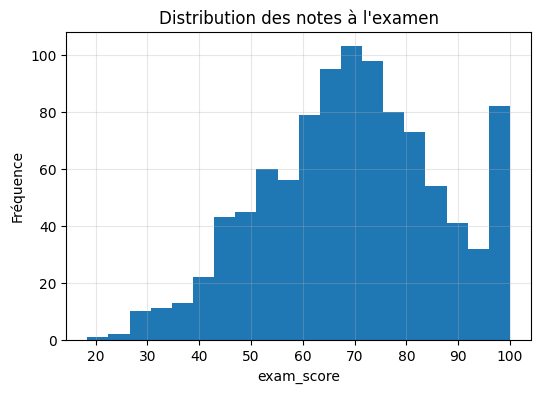

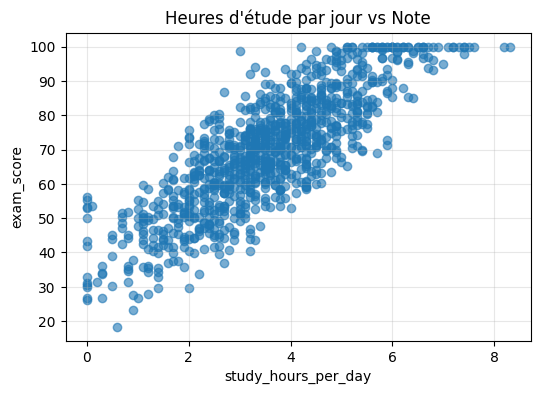

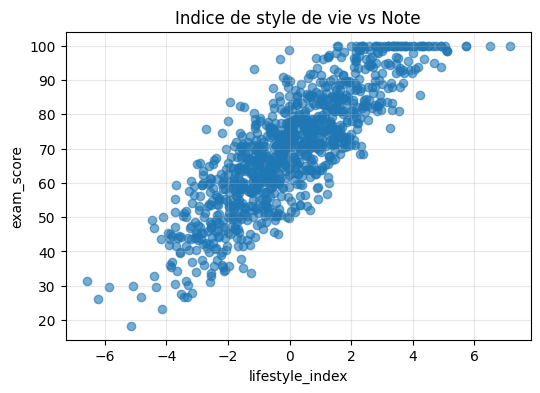

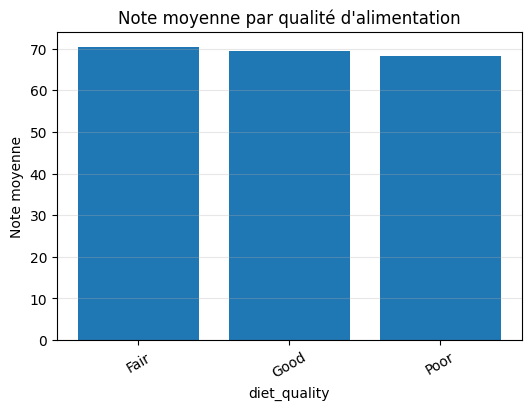

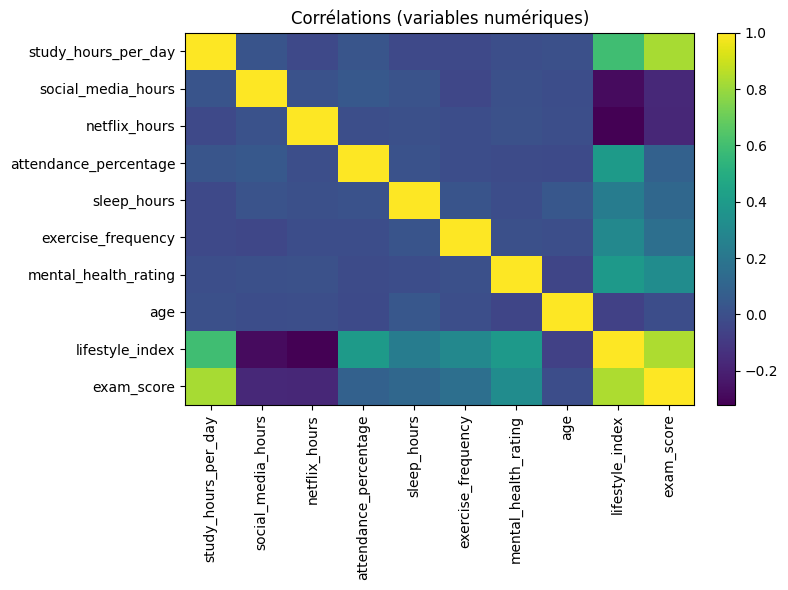

In [6]:
# ---------- Feature engineering ----------
df["lifestyle_index"] = build_lifestyle_index(df)
# ---------- Graphiques ----------
figs = []
# 1) Histogramme des notes
fig1 = plt.figure(figsize=(6,4))
plt.hist(df[TARGET], bins=20)
plt.title("Distribution des notes à l'examen")
plt.xlabel("exam_score"); plt.ylabel("Fréquence")
plt.grid(True, alpha=0.3)
figs.append(fig1)
# 2) Heures d'étude vs note
fig2 = plt.figure(figsize=(6,4))
plt.scatter(df["study_hours_per_day"], df[TARGET], alpha=0.6)
plt.title("Heures d'étude par jour vs Note")
plt.xlabel("study_hours_per_day"); plt.ylabel("exam_score")
plt.grid(True, alpha=0.3)
figs.append(fig2)
# 3) lifestyle_index vs note
fig3 = plt.figure(figsize=(6,4))
plt.scatter(df["lifestyle_index"], df[TARGET], alpha=0.6)
plt.title("Indice de style de vie vs Note")
plt.xlabel("lifestyle_index"); plt.ylabel("exam_score")
plt.grid(True, alpha=0.3)
figs.append(fig3)
# 4) Moyenne des notes par qualité d’alimentation
means = df.groupby("diet_quality")[TARGET].mean().sort_values(ascending=False)
fig4 = plt.figure(figsize=(6,4))
plt.bar(means.index.astype(str), means.values)
plt.title("Note moyenne par qualité d'alimentation")
plt.xlabel("diet_quality"); plt.ylabel("Note moyenne")
plt.xticks(rotation=30)
plt.grid(True, axis="y", alpha=0.3)
figs.append(fig4)
# 5) Heatmap des corrélations numériques
numeric_for_corr = NUMERIC_BASE + ["lifestyle_index", TARGET]
corr = df[numeric_for_corr].corr()
fig5 = plt.figure(figsize=(8,6))
im = plt.imshow(corr, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_for_corr)), numeric_for_corr, rotation=90)
plt.yticks(range(len(numeric_for_corr)), numeric_for_corr)
plt.title("Corrélations (variables numériques)")
plt.tight_layout()
figs.append(fig5)

In [7]:
# ---------- Impression corrélations avec la cible ----------
corr_with_target = corr[TARGET].sort_values(ascending=False)
print("\nCorrélations avec la note (exam_score) :")
print(corr_with_target.to_string())



Corrélations avec la note (exam_score) :
exam_score               1.000000
lifestyle_index          0.838216
study_hours_per_day      0.825419
mental_health_rating     0.321523
exercise_frequency       0.160107
sleep_hours              0.121683
attendance_percentage    0.089836
age                     -0.008907
social_media_hours      -0.166733
netflix_hours           -0.171779


In [15]:
# ---------- Sauvegarde PDF optionnelle ----------
SAVE_PDF  = True
PDF_PATH  = "Graphiques_essentiels.pdf"
if SAVE_PDF:
    with PdfPages(PDF_PATH) as pdf:
        for fig in figs:
            pdf.savefig(fig, bbox_inches="tight")
            plt.close(fig)
    print(f"\n✅ PDF sauvegardé : {os.path.abspath(PDF_PATH)}")
    # ---------- Affichage interactif (si non-PDF) ----------
# (si SAVE_PDF=True, les figures sont fermées; relancez pour les revoir)
if not SAVE_PDF:
    for fig in figs:
        fig.show()


✅ PDF sauvegardé : /content/Graphiques_essentiels.pdf
